## Preliminary Data Prep
In order to use this data for a classification problem, I did some data prep work. Our target variable is a new variable that I created called `price_gt_1M` which is a binary variable:

* 1 - house price is greater than or equal to 1 million dollars
* 0 - house price is less than a million dollars

The data for this classification problem can be found in `./data/kc_house_data_classification.csv`.

If you want to see my data prep code, see the `hw1_sklearn_dataprep.ipynb` notebook.

## The Problem

Our overall goal is to build classifier models to predict `price_gt_1M` using the the other variables. You must use sklearn Pipelines that contain your preprocessing steps and your model estimation step. We did this in the class notes.

You should do your work in a Jupyter Notebook.

### Task 1 - Folder structure

Start by creating a new project folder structure with the `cookiecutter-datascience-simple` template that I covered in Module 1. Put the data files into an appropriate folder and put this notebook in the main project folder. Any additional notebooks and/or Python files you end up creating should go in the main project folder. 

### Task 2 - Version control

Put your new project folder under version control using git. You should **NOT** track the data file. You must track all notebooks, Python scripts or additional text files you end up creating. Put appropriate information into your readme file.

### Task 3 - EDA

I suggest you start by reading the csv file into a pandas dataframe. I called my dataframe, `housing_df`.
Then start with some basic EDA. You can certainly use automated tools such as pandas-profiling, skimpy or SweetViz as I showed in the class notes. Remember, when you run some of those tools, you **must** have your notebook open in the classic Jupyter Notebook interface (and **NOT** in Jupyter Lab) Check their docs to see if Jupyter Lab is supported yet. I pip installed SweetViz and it seems to be working fine now with Jupyter Lab. As we've seen, the reports get created as HTML documents. These should go in your output folder within your project.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv

In [4]:
%matplotlib inline

In [5]:
kc_house_df = pd.read_csv("data/kc_house_data_classification.csv")

In [4]:
report = sv.analyze(kc_house_df)

/Users/anthonystronati/anaconda3/lib/python3.10/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/Users/anthonystronati/anaconda3/lib/python3.10/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |      | [  0%]   00:00 -> (? left)

/Users/anthonystronati/anaconda3/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/Users/anthonystronati/anaconda3/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/Users/anthonystronati/anaconda3/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/Users/anthonystronati/anaconda3/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' 

In [5]:
report.show_html("output/sweetviz_report.html")

Report output/sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Our data set is unbalanced, about 93% of the homes are priced under 1M. Looking at the associations in the sweetviz report we have a few variables that look to promising predictors(sqft_living, grade, sqft_living15). None of these are surprising as they things that would normaly be associated with home prices. 

### Task 4 - Categorize feature types

As we did in the Pump it Up class notes, we are going to need to create a list of categorical variables and a list of numeric variables so that we
can apply the appropriate pre-processing to each. In the notes we used the data type of the columns to create lists of numeric and categorical variables. That's not necessarily going to work here as all the variables will come in as numeric. So, you'll have to come up with another way to create lists of the categorical variables and the numeric variables. 

Since we are using regularization, all of the numeric variables will need to rescaled using the `StandardScaler`. You'll do this later as part of the `Pipeline`. For any variables that you decide should be treated as categorical in your models, use the `OneHotEncoder` on them in the preprocessing stage.

Be careful, just because a variable has a numeric datatype in the pandas dataframe, it does **not** mean that it's necessarily a numeric variable in the context of the classification models. Think about each column and look at your EDA reports and decide whether or not it's truly numeric or needs to be treated as categorical data in the models.  

Even though our target variable, `price_gt_1M`, is categorical, you do **NOT** need to do any preprocessing on it. As I mentioned in our class notes, scikit-learn will automatically detect that and will do any encoding needed on its own.

Finally, you'll partition the dataset into training and test datasets for modeling: 

* I broke up the `housing_df` into two separate dataframes that I called `X` and `y`, to use in the models. Here's my code for that:

```
X = housing_df.iloc[:, 0:18]
y = housing_df.iloc[:, 18]
```

* Please use the following code for your data partitioning so that we all end up with the same training and test split:

```
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73)
```

In [6]:
kc_house_df.dtypes

bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
price_gt_1M        int64
dtype: object

In [7]:
# Set a limit for the number of unique values
unique_limit = 30 # I just keep changing this number until it gave me a list of catigorical I liked. 

# create variables
categorical_vars = []
numeric_vars = []

# loop through all columns
for column in kc_house_df.columns:
    unique_values = kc_house_df[column].nunique()  # Count the number of unique values
    
    if unique_values <= unique_limit:
        categorical_vars.append(column)
    else:
        numeric_vars.append(column)


In [8]:
categorical_vars

['bedrooms',
 'bathrooms',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'price_gt_1M']

In [9]:
numeric_vars

['sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [10]:
categorical_vars = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade','yr_built','yr_renovated','zipcode']
numeric_vars = ['sqft_living','sqft_lot','sqft_above','sqft_basement','lat','long','sqft_living15','sqft_lot15']



In [11]:
kc_house_df.loc[:, categorical_vars].describe()

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode
count,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,3.370842,2.114757,1.494309,0.007542,0.234303,3.409430,7.656873,1971.005136,84.402258,98077.939805
std,0.930062,0.770163,0.539989,0.086517,0.766318,0.650743,1.175459,29.373411,401.679240,53.505026
min,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1900.000000,0.000000,98001.000000
25%,3.000000,1.750000,1.000000,0.000000,0.000000,3.000000,7.000000,1951.000000,0.000000,98033.000000
50%,3.000000,2.250000,1.500000,0.000000,0.000000,3.000000,7.000000,1975.000000,0.000000,98065.000000
75%,4.000000,2.500000,2.000000,0.000000,0.000000,4.000000,8.000000,1997.000000,0.000000,98118.000000
max,33.000000,8.000000,3.500000,1.000000,4.000000,5.000000,13.000000,2015.000000,2015.000000,98199.000000


In [12]:
kc_house_df.loc[:, numeric_vars].describe()

,sqft_living,sqft_lot,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15
count,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,2079.899736,1.510697e+04,1788.390691,291.509045,47.560053,-122.213896,1986.552492,12768.455652
std,918.440897,4.142051e+04,828.090978,442.575043,0.138564,0.140828,685.391304,27304.179631
min,290.000000,5.200000e+02,290.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,1427.000000,5.040000e+03,1190.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,1910.000000,7.618000e+03,1560.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,2550.000000,1.068800e+04,2210.000000,560.000000,47.678000,-122.125000,2360.000000,10083.000000
max,13540.000000,1.651359e+06,9410.000000,4820.000000,47.777600,-121.315000,6210.000000,871200.000000


In [13]:
categorical_vars_idx = [kc_house_df.columns.get_loc(c) for c in categorical_vars]
categorical_vars_idx

[0, 1, 4, 5, 6, 7, 8, 11, 12, 13]

In [14]:
kc_house_df.iloc[:, categorical_vars_idx].nunique()

bedrooms         13
bathrooms        30
floors            6
waterfront        2
view              5
condition         5
grade            12
yr_built        116
yr_renovated     70
zipcode          70
dtype: int64

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split

In [16]:
# Create transformer objects
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_vars),
        ('cat', categorical_transformer, categorical_vars)])

In [17]:
# separte predictors and target
X = kc_house_df.iloc[:, 0:18]
y = kc_house_df.iloc[:, 18]

In [18]:
X.info

<bound method DataFrame.info of        bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0             3       1.00         1180      5650     1.0           0     0   
1             3       2.25         2570      7242     2.0           0     0   
2             2       1.00          770     10000     1.0           0     0   
3             4       3.00         1960      5000     1.0           0     0   
4             3       2.00         1680      8080     1.0           0     0   
...         ...        ...          ...       ...     ...         ...   ...   
21608         3       2.50         1530      1131     3.0           0     0   
21609         4       2.50         2310      5813     2.0           0     0   
21610         2       0.75         1020      1350     2.0           0     0   
21611         3       2.50         1600      2388     2.0           0     0   
21612         2       0.75         1020      1076     2.0           0     0   

       condition  g

In [19]:
# Partition training data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73)

In [20]:
y_train.info

<bound method Series.info of 13067    0
17417    0
1290     0
13137    0
15815    0
        ..
13704    0
16144    0
8586     0
4014     0
21398    0
Name: price_gt_1M, Length: 17290, dtype: int64>

In [21]:
X_train.info

<bound method DataFrame.info of        bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
13067         3       2.25         1670      7881     1.0           0     0   
17417         5       2.75         3100      5298     2.0           0     0   
1290          3       2.25         2470     10290     2.0           0     0   
13137         3       1.75         2610    117176     1.0           0     0   
15815         3       1.75         1400     18002     1.0           0     0   
...         ...        ...          ...       ...     ...         ...   ...   
13704         3       1.75         2200      7200     1.0           0     0   
16144         4       2.50         2980      5896     2.0           0     0   
8586          3       2.00         2420     17859     1.0           0     1   
4014          3       1.75         2160      6272     1.0           0     0   
21398         4       2.50         1660      2500     2.0           0     0   

       condition  g

### Task 4 - Logistic regression models

You are going to build a few different logistic regression models using all of the variables in our housing dataset. For each of these models you will:

- Create a pipeline to do the preprocessing (the scaling and encoding) and the modeling (we did this in the Pump it Up project)
- I'll be giving you different specifications and hyperparameter parameter settings to try
- You'll be scoring the models on overall accuracy for both the training and test data. Discuss any evidence of overfitting or underfitting as well as how the model does in comparison to the null model.
- There will be some additional tasks/questions for each model - details below

**IMPORTANT** You always should put summary comments in one or more markdown cells. Do **NOT** write them as comments in a code cell. The whole point of Jupyter notebooks is to be able to mix markdown cells with code cells. Yes, you should also include code comments but those are different than analysis comments.

#### Model 0: The null model

We always start with the simplest possible model and we call it the *null model*. For binary classification models, the null model is usually just to predict that each observation will fall into whichever class is most prevalent. In other words, what would be the performance of a model in which we just predict 0 for everyone? Scikit-learn has a way to create simple null models for classification with the `sklearn.dummy.DummyClassifier` class. See https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html for the details. You must use this class to create your null model.

#### Model 1: Ridge regression with C=1.0

Build a ridge regression model to predict `price_gt_1M` and use the default value of `C=1.0`. I used the following additional options with the `LogisticRegression` model - `solver='saga', max_iter=2000`. Feel free to change these if you want. AFter fitting the model, compute its accuracy score for training and test and write out a little summary (f-strings are useful). Here's an example:

    Training score: 0.974
    Test score: 0.971

Create confusion matrices for both training and test.

Also, create a plot of the coefficients (as we did in the notes). If you want to use that `coef_plot` function we used in the notes, you'll have
to make a few modifications because we only have one set of coefficients (since we have a binary classification problem as opposed to a 3-class problem in Pump it Up).

#### Model 2: Lasso regression with C=1.0

Same as Model 1, but use lasso regression instead of ridge regression. Create the same outputs and compare the performance to the ridge regression model.

#### Model 3: Lasso regression with C=0.01

Fit another lasso regression but use `C=0.01`. Does this enforce more or less regularization? Create the same outputs and compare the performance to the first two models. Discuss why the plot looks so different than the previous plots.

#### Model 4: Lasso regression with optimal C value

Now use `LogisticRegressionCV` to fit a model and let sklearn determine the optimal `C` value to use. Again, compute the accuracy score and confusion matrices. Also, print out the optimal value of `C`. Does regularization help for this problem?

### Task 5 - Simple decision tree
Now fit a decision tree to predict `price_gt_1M`. As we did above, for both train and test, compute the accuracy score, create a confusion matrix, and discuss the performance relative to your logistic regression models. Obviously you do not need to create a coefficient plot (why not?). 

**HACKER EXTRA:** See if you can figure out how to display the fitted tree so that it's readable. :)
 




In [22]:
from sklearn.dummy import DummyClassifier

In [23]:
# Create transformer objects
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_vars),
        ('cat', categorical_transformer, categorical_vars)])

# Classifier model 0 (null)
clf_model = DummyClassifier(strategy="most_frequent") 

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_model)])

In [24]:
clf.fit(X_train, y_train)

print(f"Training score: {clf.score(X_train, y_train):.3f}")
print(f"Test score: {clf.score(X_test, y_test):.3f}")

Training score: 0.933
Test score: 0.924


### The null model it pretty good because our data is unbalanced 92% with the test data is good so other models will at least need to beat that level of accuracy. 

## Model 1: L2 C = 1

In [25]:
#Create transformer objects
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_vars),
        ('cat', categorical_transformer, categorical_vars)])

# Classifier model 1 
clf_l2_C1 = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=500)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_l2_C1 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_l2_C1)])

In [26]:
clf_l2_C1.fit(X_train, y_train)

print(f"Training score: {clf_l2_C1.score(X_train, y_train):.3f}")
print(f"Test score: {clf_l2_C1.score(X_test, y_test):.3f}")

Training score: 0.977
Test score: 0.969


/Users/anthonystronati/anaconda3/envs/aap/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### This is a clear improvment over our null model. There are no signs of overfitting as the Test and Training scores are in line with each other. 

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [28]:
y_pred = clf_l2_C1.predict(X_train)
cm_clf_l2_C1_train = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(cm_clf_l2_C1_train)

Confusion Matrix:
[[16016   111]
 [  288   875]]


Confusion Matrix:
[[3959   35]
 [  97  232]]


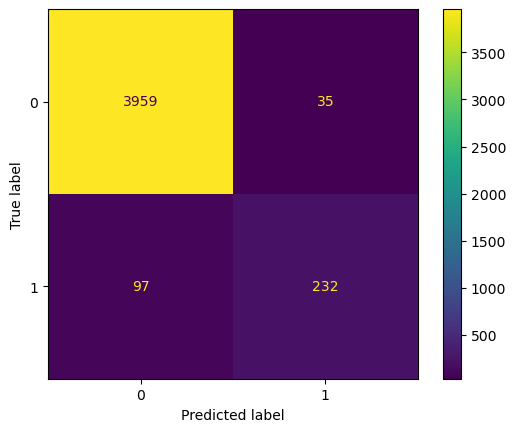

In [29]:
y_pred = clf_l2_C1.predict(X_test)
cm_clf_l2_C1_test = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm_clf_l2_C1_test)

# make it look nice
disp = ConfusionMatrixDisplay(confusion_matrix=cm_clf_l2_C1_test, display_labels=clf.classes_)
disp.plot()
plt.show()


### The confusion matrix shows us how the model is making more mistakes valuing the homes as under 1M, this is makes senses since the data set is unbalanced.

In [30]:
clf_l2_C1.named_steps['classifier'].coef_.shape

(1, 334)

In [31]:
clf_l2_C1.steps[1]

('classifier', LogisticRegression(C=1, max_iter=500, solver='saga'))

In [32]:
def coef_plot(model, title=None):
    fig, ax = plt.subplots(1)
       
    if title:
        ax.set_title(title)

    ax.plot(model.named_steps['classifier'].coef_[0])


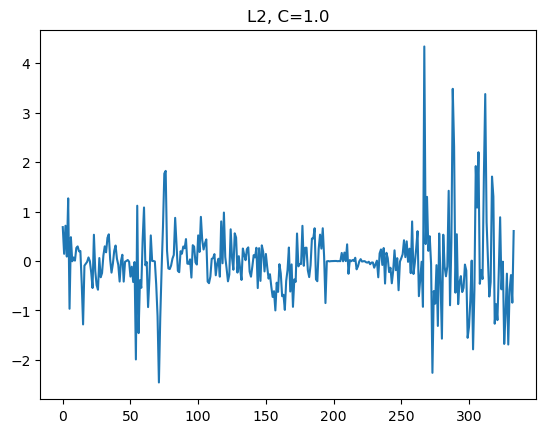

In [33]:
coef_plot(clf_l2_C1, 'L2, C=1.0')

## Model 2: L1 C = 1

In [34]:
#Create transformer objects
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_vars),
        ('cat', categorical_transformer, categorical_vars)])

# Classifier model 2 
clf_l1_C1 = LogisticRegression(penalty='l1', C=1, solver='saga', max_iter=500)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_l1_C1 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_l1_C1)])

In [35]:
clf_l1_C1.fit(X_train, y_train)

print(f"Training score: {clf_l1_C1.score(X_train, y_train):.3f}")
print(f"Test score: {clf_l1_C1.score(X_test, y_test):.3f}")

Training score: 0.977
Test score: 0.971


/Users/anthonystronati/anaconda3/envs/aap/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### The L1(Lasso)penalty is scoreing about the same as the Ridge model. Both have the same amount of regularization so this is not surprising. 

In [36]:
y_pred = clf_l1_C1.predict(X_train)
cm_clf_l1_C1_train = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(cm_clf_l1_C1_train)

Confusion Matrix:
[[16010   117]
 [  288   875]]


Confusion Matrix:
[[3963   31]
 [  93  236]]


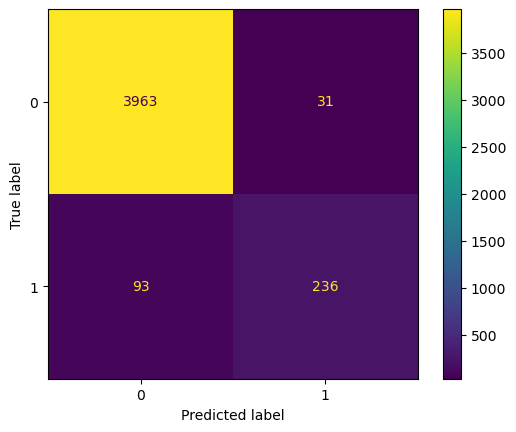

In [37]:
y_pred = clf_l1_C1.predict(X_test)
cm_clf_l1_C1_test = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm_clf_l1_C1_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_clf_l1_C1_test, display_labels=clf.classes_)
disp.plot()
plt.show()

### Nothing super interesting here, it is very similar to our previous model.

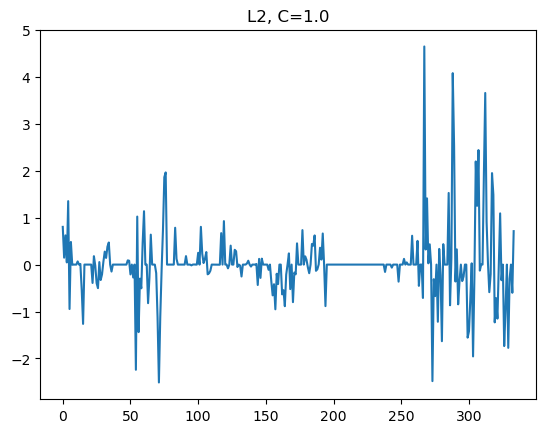

In [38]:
coef_plot(clf_l1_C1, 'L2, C=1.0')

## Model 3: L1 C = .01

In [39]:
#Create transformer objects
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_vars),
        ('cat', categorical_transformer, categorical_vars)])

# Classifier model 3 
clf_l1_C01 = LogisticRegression(penalty='l1', C=0.01, solver='saga', max_iter=500)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_l1_C01 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_l1_C01)])

In [40]:
clf_l1_C01.fit(X_train, y_train)

print(f"Training score: {clf_l1_C01.score(X_train, y_train):.3f}")
print(f"Test score: {clf_l1_C01.score(X_test, y_test):.3f}")

Training score: 0.954
Test score: 0.949


/Users/anthonystronati/anaconda3/envs/aap/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### With the stronger regularization (C=.01 vs.1) the model performance decreases. The Lasso model with C = 1 had and accuracy about 2 percentange points hight the the 95% we see here.

In [41]:
y_pred = clf_l1_C01.predict(X_train)
cm_clf_l1_C01_train = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(cm_clf_l1_C01_train)

Confusion Matrix:
[[16002   125]
 [  665   498]]


Confusion Matrix:
[[3964   30]
 [ 191  138]]


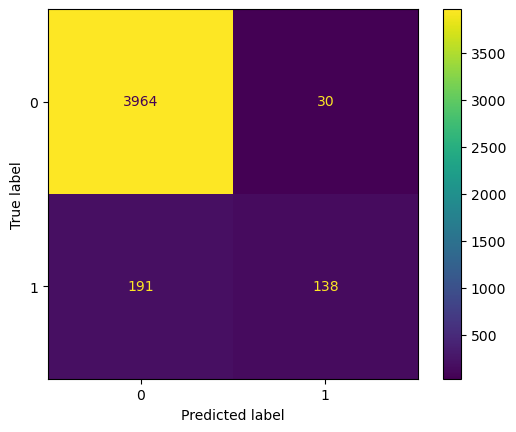

In [42]:
y_pred = clf_l1_C01.predict(X_test)
cm_clf_l1_C01_test = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm_clf_l1_C01_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_clf_l1_C01_test, display_labels=clf.classes_)
disp.plot()
plt.show()

### We see a jump in the false negatives which decreases our sensivitity and in turn decreases the accuracy score.

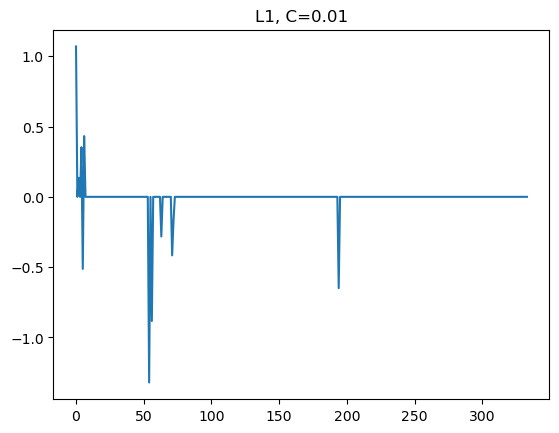

In [43]:
coef_plot(clf_l1_C01, 'L1, C=0.01')

## Model 4: L1 C = "Optimal"

In [44]:
from sklearn.linear_model import LogisticRegressionCV

In [61]:
# Example with a range of C values
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [62]:
#Create transformer objects
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_vars),
        ('cat', categorical_transformer, categorical_vars)])

# Classifier model 3 
clf_optimize = LogisticRegressionCV(Cs=Cs, penalty='l1', cv=5, solver='saga', max_iter=500)

In [63]:
clf_optimize.fit(X_train, y_train)

/Users/anthonystronati/anaconda3/envs/aap/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anthonystronati/anaconda3/envs/aap/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anthonystronati/anaconda3/envs/aap/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anthonystronati/anaconda3/envs/aap/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anthonystronati/anaconda3/envs/aap/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10, 100, 1000], cv=5,
                     max_iter=500, penalty='l1', solver='saga')

In [64]:
best_C = clf_optimize.C_[0]
print("Best C:", best_C)

Best C: 100.0


In [65]:
#Create transformer objects
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_vars),
        ('cat', categorical_transformer, categorical_vars)])

# Classifier model 2 
clf_l1_C100 = LogisticRegression(penalty='l1', C=100, solver='saga', max_iter=500)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_l1_C100 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_l1_C100)])

In [60]:
clf_l1_C100.fit(X_train, y_train)

print(f"Training score: {clf_l1_C100.score(X_train, y_train):.3f}")
print(f"Test score: {clf_l1_C100.score(X_test, y_test):.3f}")

Training score: 0.977
Test score: 0.969


/Users/anthonystronati/anaconda3/envs/aap/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [54]:
y_pred = clf_l1_C100.predict(X_train)
cm_clf_l1_C100_train = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(cm_clf_l1_C100_train)

Confusion Matrix:
[[16002   125]
 [  269   894]]


Confusion Matrix:
[[3957   37]
 [  96  233]]


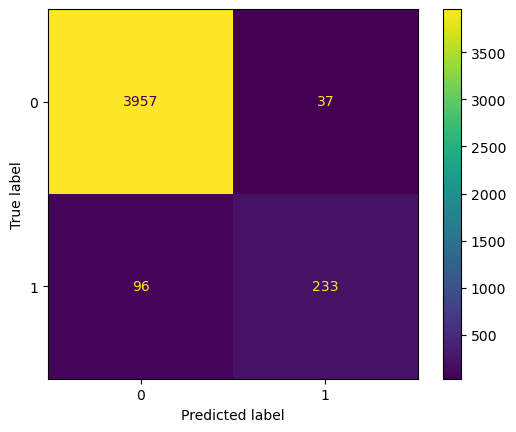

In [55]:
y_pred = clf_l1_C100.predict(X_test)
cm_clf_l1_C100_test = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm_clf_l1_C100_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_clf_l1_C100_test, display_labels=clf.classes_)
disp.plot()
plt.show()

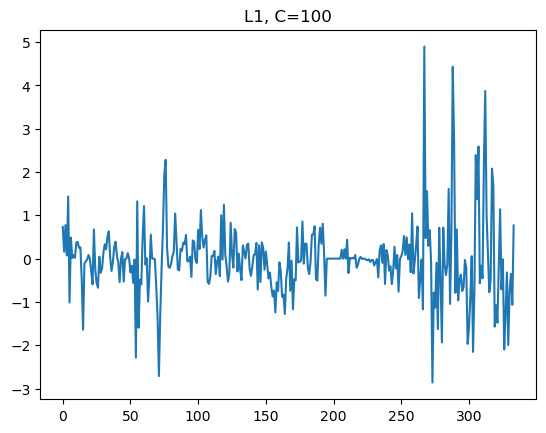

In [199]:
coef_plot(clf_l1_C100, 'L1, C=100')

### Regularizatin does not help in this model. C's higher than one are producing better accruacy scores the C's below one (ie. .01)which apply stronger regularization.

## Model 5: Decision Tree

In [77]:
from sklearn.tree import DecisionTreeClassifier

#Create transformer objects
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_vars),
        ('cat', categorical_transformer, categorical_vars)])

# Classifier model 2 
clf_tree = DecisionTreeClassifier(random_state=0)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_tree = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_tree)])

In [78]:
clf_tree.fit(X_train, y_train)

print(f"Training score: {clf_tree.score(X_train, y_train):.3f}")
print(f"Test score: {clf_tree.score(X_test, y_test):.3f}")

Training score: 1.000
Test score: 0.959


### The decsision tree performs perfectly on the training data but the test score is slightly lower than our better logistic regression models. This could indicate overfitting.

In [79]:
y_pred = clf_tree.predict(X_train)
cm_clf_tree_train = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(cm_clf_tree_train)

Confusion Matrix:
[[16127     0]
 [    0  1163]]


Confusion Matrix:
[[3908   86]
 [  92  237]]


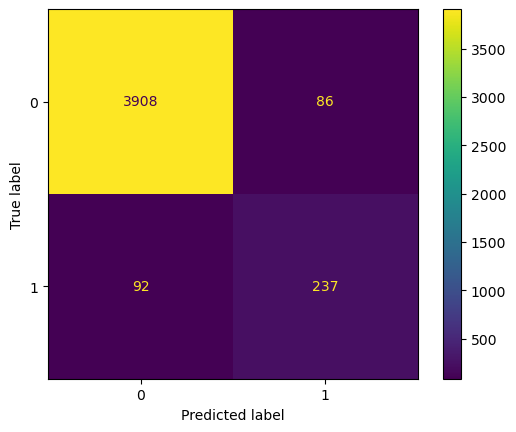

In [80]:
y_pred = clf_tree.predict(X_test)
cm_clf_tree_test = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm_clf_tree_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_clf_tree_test, display_labels=clf.classes_)
disp.plot()
plt.show()

### THe Descicion tree has a higher flase negatives than the logistic models. The lower specificity is what brings this accuracy score down.

TypeError: can only concatenate str (not "numpy.int64") to str

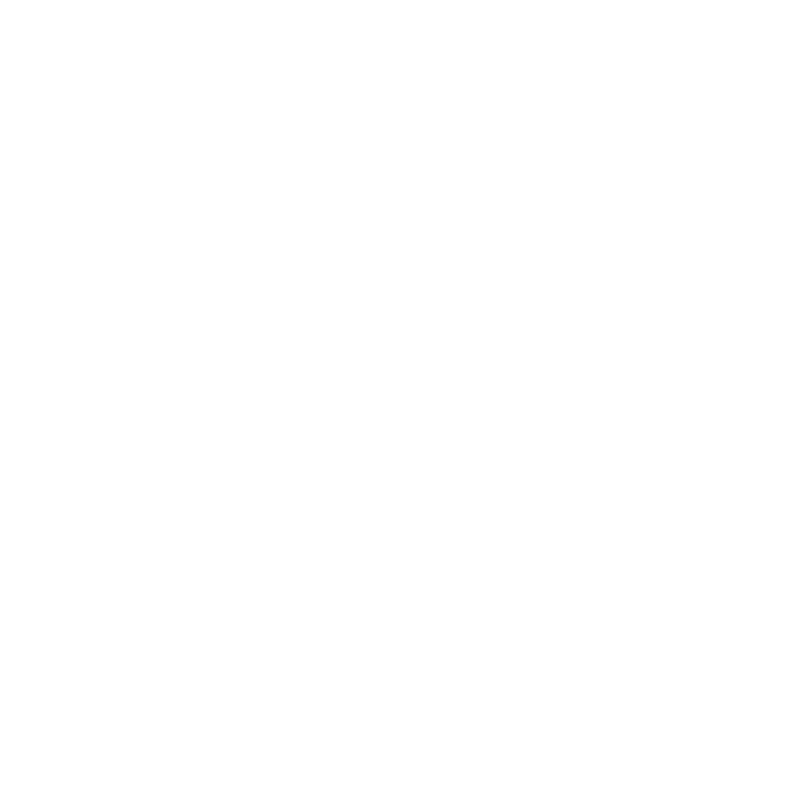

In [82]:
# Plot the decision tree
fig, ax = plt.subplots(figsize=(10, 10))
tree.plot_tree(clf_tree.named_steps['classifier'], feature_names=feature_names, class_names=clf_tree.classes_, ax=ax)

# Show the plot
plt.show()


### Task 6 - a little error exploration (more challenging)

This will challenge your pandas and your general data manipulation skills. Just give it your best shot. If you don't get, you don't get it. It doesn't require much code - just the right code. :)

I also include another data file called `kc_house_data_regression.csv` in which the target variable is `price`. Everything else is exactly the same, including the order of the rows. So, here's your challenge. Using Model 2 (the lasso model with `C=1.0`), start by using the `predict` method to generate an array of predictions for the original test data. Obviously, some of the predictions are correct and some of them are not. It would be interesting to know more about the kinds of errors our model is making. We can see some things from the confusion matrix. However, since we don't have the actual `price` value, it's hard to visualize how the errors relate to it. For example, are we only making errors when the price is really close to 1 million? One way to visualize this is to create a histogram of the actual prices **only for those rows in test that we got wrong**. What makes this tricky? A few things:

* As I already mentioned, `price` is not in our original data but is in the `kc_house_data_regression.csv` dataset. Remember, other than the target variable, this dataset is identical (including the index) to the one we used above for classification.
* We partitioned the classification dataset into training and test datasets.
* In order to create the histogram, we simply need a Series (or array) of `price` values corresponding to the predictions in test that we got wrong.

**HINTS** 

* The pandas `join` method will come in handy.
* The pandas `.loc` selector can take a boolean array as an input for selecting rows or columns. Using one to select rows is quite useful for this problem.

In [89]:
house_reg_df = pd.read_csv("data/kc_house_data_regression.csv")

In [92]:
house_reg_df.head

<bound method NDFrame.head of        bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0             3       1.00         1180      5650     1.0           0     0   
1             3       2.25         2570      7242     2.0           0     0   
2             2       1.00          770     10000     1.0           0     0   
3             4       3.00         1960      5000     1.0           0     0   
4             3       2.00         1680      8080     1.0           0     0   
...         ...        ...          ...       ...     ...         ...   ...   
21608         3       2.50         1530      1131     3.0           0     0   
21609         4       2.50         2310      5813     2.0           0     0   
21610         2       0.75         1020      1350     2.0           0     0   
21611         3       2.50         1600      2388     2.0           0     0   
21612         2       0.75         1020      1076     2.0           0     0   

       condition  gra

In [100]:
kc_house_df.head

<bound method NDFrame.head of        bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0             3       1.00         1180      5650     1.0           0     0   
1             3       2.25         2570      7242     2.0           0     0   
2             2       1.00          770     10000     1.0           0     0   
3             4       3.00         1960      5000     1.0           0     0   
4             3       2.00         1680      8080     1.0           0     0   
...         ...        ...          ...       ...     ...         ...   ...   
21608         3       2.50         1530      1131     3.0           0     0   
21609         4       2.50         2310      5813     2.0           0     0   
21610         2       0.75         1020      1350     2.0           0     0   
21611         3       2.50         1600      2388     2.0           0     0   
21612         2       0.75         1020      1076     2.0           0     0   

       condition  gra

In [ ]:
yreg = house_reg_df.iloc[:, 18]

In [102]:
# Generate predictions for the original test data
predictions = clf_l1_C1.predict(X_test)

# Convert the predictions array into a DataFrame
predictions_df = pd.DataFrame(predictions, columns=["predicted_price"])

# Get the index of the incorrect predictions
incorrect_predictions_idx = y_test != predictions

# Filter the regression dataset to get the actual prices for the incorrect predictions
actual_prices = house_reg_df.loc[incorrect_predictions_idx, "price"]

# Plot the histogram of actual prices for incorrect predictions
actual_prices.hist(bins=30)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

## Optional Hacker Extra Credit tasks
I always like to include some extra credit tasks for those who want to push themselves a little further. For this problem, consider doing one or more of the following:

* Try out the [Histogram based Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html?highlight=histogram%20based%20gradient%20boosting%20classifier) shown in the optional materials at the end of Module 2. Compare its performance to logistic regression and the random forest.
* I also include another data file called `kc_house_data_regression.csv` in which the target variable is `price`. Use sklearn's `LassoCV` to find a good regression model for predicting `price`.

## Deliverables
You should simply compress your entire project folder as either a zip file or a tar.gz file (do **NOT** ever use WinRAR to create rar files in this class). Note that when you do this, your "hidden" `.git` folder will get included. So, I'll be able to tell that you put the project under version control and I'll be able to look at your project folder structure. Before compressing the project folder to submit it:

* make sure all of your notebooks and other files are in the main project folder and have good filenames,
* make sure you've committed all of your changes (git),
* upload your compressed folder in Moodle.